In [1]:
!pip install librosa soundfile matplotlib numpy scipy

import os
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import correlate


"She judged the blue pen, put it on the table, and quietly whispered yes."

In [9]:
AUDIO_PATH = '/content/blue_pen_me.m4a'
TARGET_SR = 16000

y, sr = librosa.load(AUDIO_PATH, sr=TARGET_SR, mono=True)
print(f'Loaded {AUDIO_PATH}: {y.shape[0]} samples, {sr} Hz')


/tmp/ipython-input-3930287244.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(AUDIO_PATH, sr=TARGET_SR, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Loaded /content/blue_pen_me.m4a: 115371 samples, 16000 Hz


Voiced candidate segments:


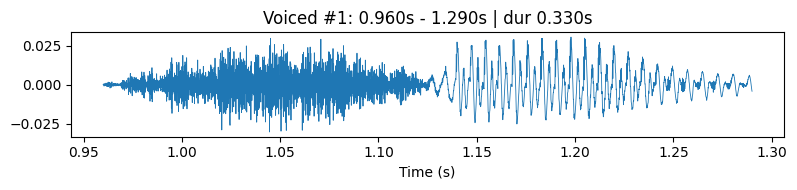

RMS: 0.0092, ZCR mean: 0.2132, ZCR var: 0.018557, Periodicity: 0.7532



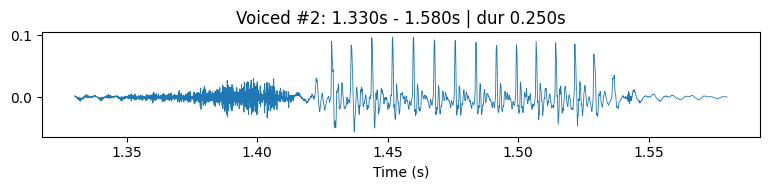

RMS: 0.0168, ZCR mean: 0.1592, ZCR var: 0.020412, Periodicity: 0.9273



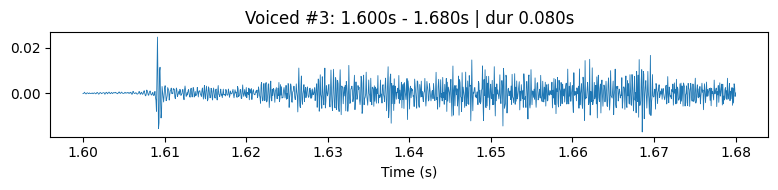

RMS: 0.0042, ZCR mean: 0.4658, ZCR var: 0.017961, Periodicity: 0.3218



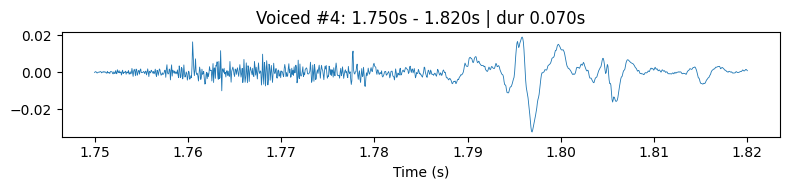

RMS: 0.0053, ZCR mean: 0.2284, ZCR var: 0.028083, Periodicity: 0.8775



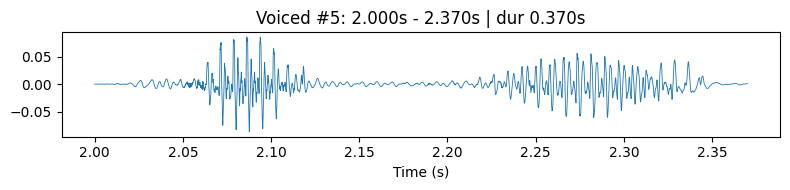

RMS: 0.0174, ZCR mean: 0.0456, ZCR var: 0.000370, Periodicity: 0.9854



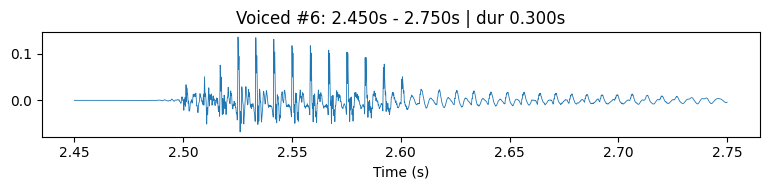

RMS: 0.0165, ZCR mean: 0.0981, ZCR var: 0.017167, Periodicity: 0.9424



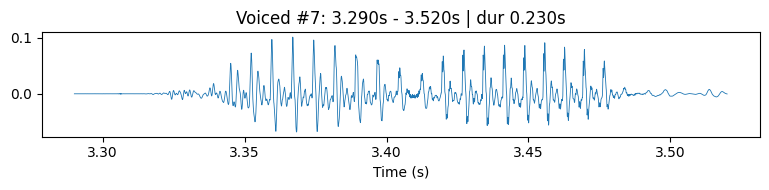

RMS: 0.0211, ZCR mean: 0.1140, ZCR var: 0.019391, Periodicity: 0.9782



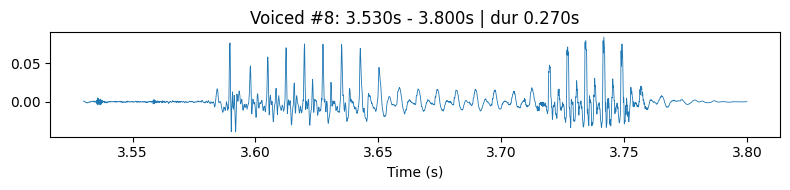

RMS: 0.0138, ZCR mean: 0.0829, ZCR var: 0.004337, Periodicity: 0.9723



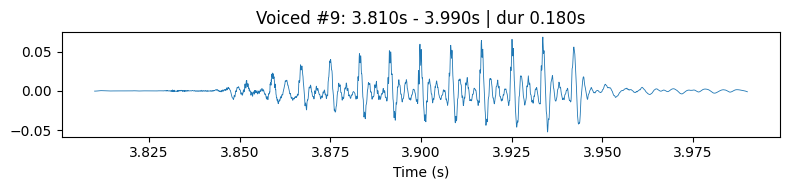

RMS: 0.0131, ZCR mean: 0.0903, ZCR var: 0.005613, Periodicity: 0.9757



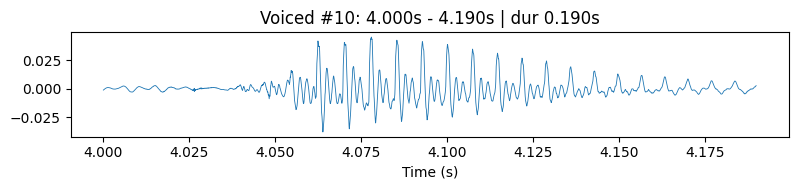

RMS: 0.0100, ZCR mean: 0.0452, ZCR var: 0.000411, Periodicity: 0.9866



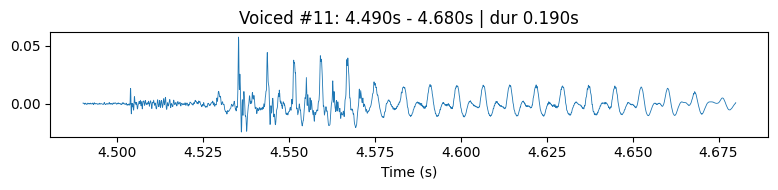

RMS: 0.0078, ZCR mean: 0.0736, ZCR var: 0.002708, Periodicity: 0.9752



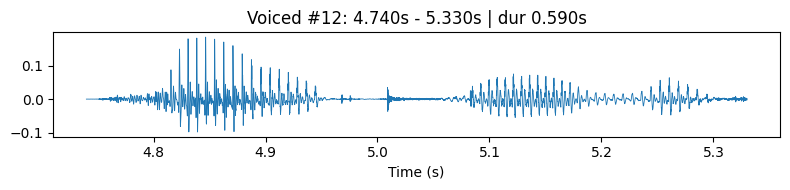

RMS: 0.0208, ZCR mean: 0.1145, ZCR var: 0.008974, Periodicity: 0.9655



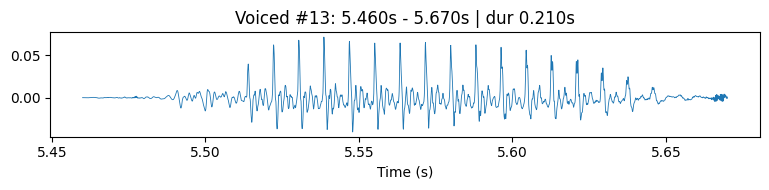

RMS: 0.0129, ZCR mean: 0.0605, ZCR var: 0.000323, Periodicity: 0.9759



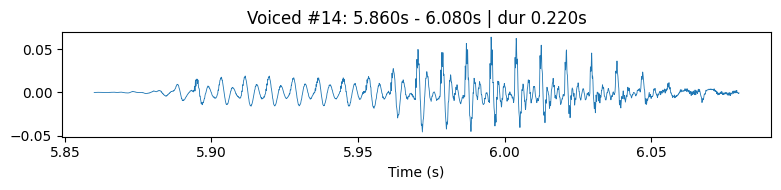

RMS: 0.0114, ZCR mean: 0.0524, ZCR var: 0.000345, Periodicity: 0.9748

Unvoiced candidate segments:


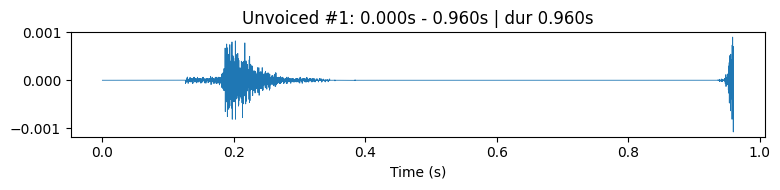

RMS: 0.0001, ZCR mean: 0.1290, ZCR var: 0.042403, Periodicity: 0.6821



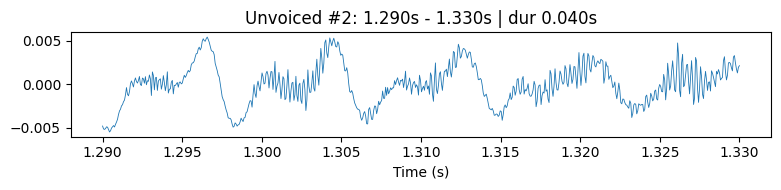

RMS: 0.0023, ZCR mean: 0.1625, ZCR var: 0.001772, Periodicity: 0.8900



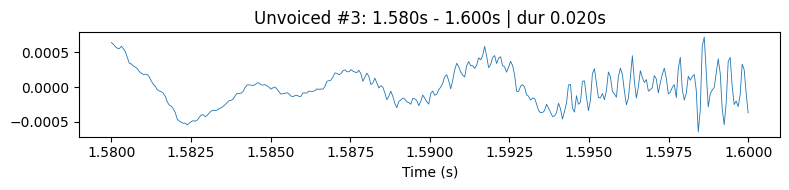

RMS: 0.0003, ZCR mean: 0.0833, ZCR var: 0.001460, Periodicity: 0.8330



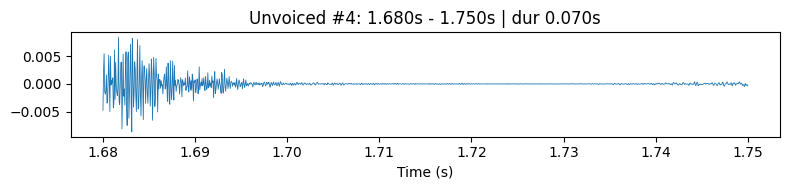

RMS: 0.0013, ZCR mean: 0.4369, ZCR var: 0.017459, Periodicity: 0.5612



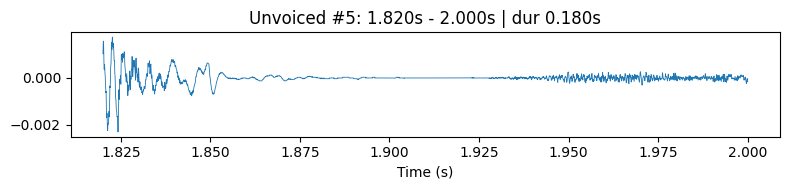

RMS: 0.0003, ZCR mean: 0.2887, ZCR var: 0.037154, Periodicity: 0.9523



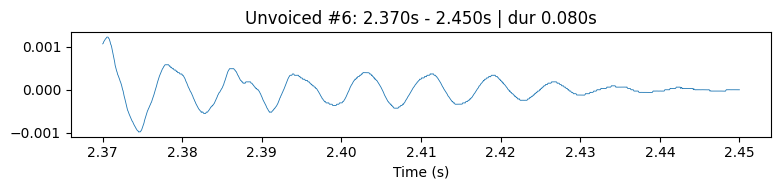

RMS: 0.0003, ZCR mean: 0.0608, ZCR var: 0.004354, Periodicity: 0.9939



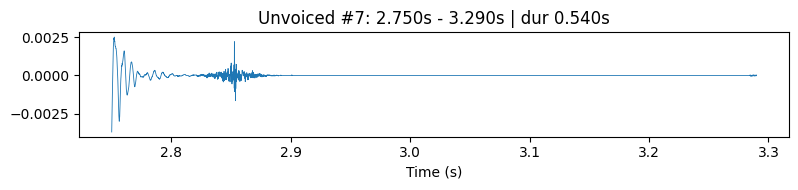

RMS: 0.0003, ZCR mean: 0.0922, ZCR var: 0.029052, Periodicity: 0.9629



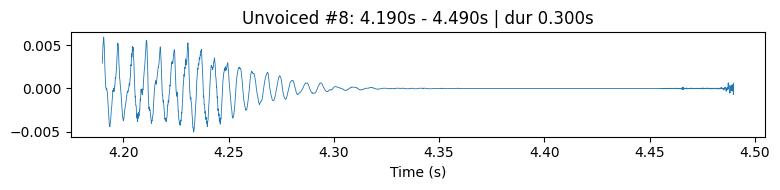

RMS: 0.0013, ZCR mean: 0.1715, ZCR var: 0.055017, Periodicity: 0.9953



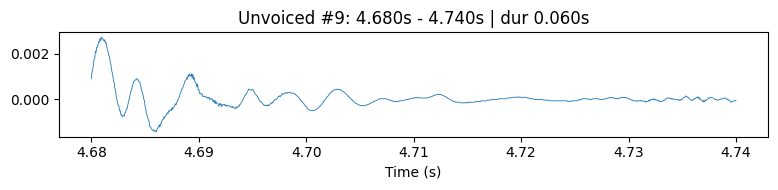

RMS: 0.0005, ZCR mean: 0.0714, ZCR var: 0.001930, Periodicity: 0.9922



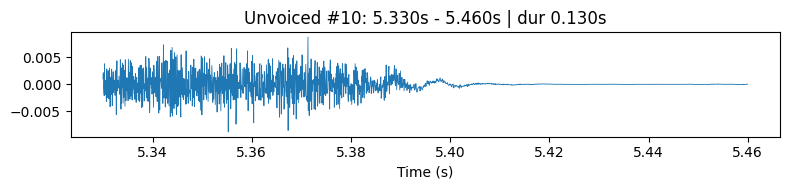

RMS: 0.0017, ZCR mean: 0.4200, ZCR var: 0.028146, Periodicity: 0.1164



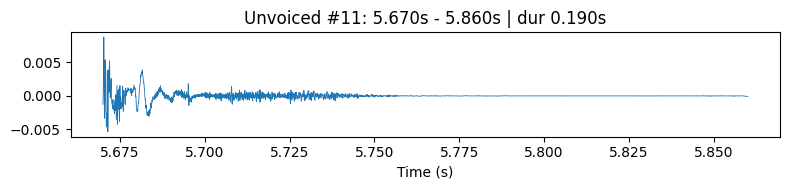

RMS: 0.0006, ZCR mean: 0.4508, ZCR var: 0.036594, Periodicity: 0.7620



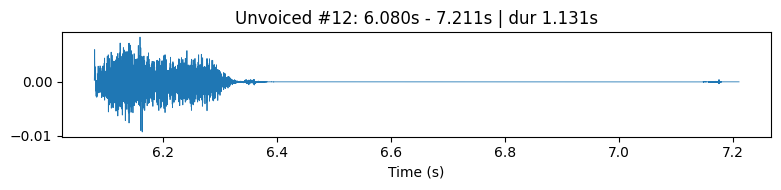

RMS: 0.0009, ZCR mean: 0.1776, ZCR var: 0.064289, Periodicity: 0.1383



In [10]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import correlate

frame_len = int(0.025 * sr)
hop_len = int(0.010 * sr)

frames = librosa.util.frame(y, frame_length=frame_len, hop_length=hop_len).T
energy = np.sum(frames**2, axis=1)
zcr = librosa.feature.zero_crossing_rate(y, frame_length=frame_len, hop_length=hop_len)[0]

import scipy.ndimage as ndi
energy_smooth = ndi.gaussian_filter1d(energy, sigma=2)

energy_thresh = np.median(energy_smooth) * 1.2
voiced_mask_frames = energy_smooth > energy_thresh

mask_samples = np.repeat(voiced_mask_frames, hop_len)
mask_samples = np.pad(mask_samples, (0, max(0, len(y)-len(mask_samples))), mode='constant')[:len(y)]

def find_segments(mask):
    segments = []
    in_seg = False
    start = 0
    for i, m in enumerate(mask):
        if m and not in_seg:
            in_seg = True
            start = i
        elif not m and in_seg:
            in_seg = False
            end = i
            segments.append((start, end))
    if in_seg:
        segments.append((start, len(mask)))
    return segments

voiced_segments = find_segments(mask_samples)
unvoiced_segments = []
prev_end = 0
for s,e in voiced_segments:
    if s - prev_end > int(0.01*sr):
        unvoiced_segments.append((prev_end, s))
    prev_end = e
if prev_end < len(y):
    unvoiced_segments.append((prev_end, len(y)))

def rms(sig):
    return np.sqrt(np.mean(sig**2))

def periodicity_metric(sig, sr, max_lag_ms=20):
    if len(sig) < 2: return 0.0
    sig = sig - np.mean(sig)
    corr = correlate(sig, sig, mode='full')
    corr = corr[corr.size//2:]
    max_lag = int(max_lag_ms/1000 * sr)
    if max_lag >= len(corr): max_lag = len(corr)-1
    peak = np.max(corr[1:max_lag]) if max_lag>1 else 0.0
    return peak / (corr[0] + 1e-12)

def collect_info(segments, label):
    info = []
    for (s,e) in segments:
        seg = y[s:e]
        if len(seg) < int(0.005*sr):
            continue
        info.append({
            'start_s': s/sr,
            'end_s': e/sr,
            'duration_s': (e-s)/sr,
            'rms': float(rms(seg)),
            'zcr_mean': float(np.mean(librosa.feature.zero_crossing_rate(seg, frame_length=frame_len, hop_length=hop_len)[0])),
            'zcr_var': float(np.var(librosa.feature.zero_crossing_rate(seg, frame_length=frame_len, hop_length=hop_len)[0])),
            'periodicity': float(periodicity_metric(seg, sr)),
            'samples': seg
        })
    return info

voiced_info = collect_info(voiced_segments, 'voiced')
unvoiced_info = collect_info(unvoiced_segments, 'unvoiced')

def plot_segments(info_list, title_prefix):
    for i,info in enumerate(info_list):
        seg = info['samples']
        t = np.linspace(info['start_s'], info['end_s'], len(seg))
        plt.figure(figsize=(8,2))
        plt.plot(t, seg, linewidth=0.6)
        plt.title(f"{title_prefix} #{i+1}: {info['start_s']:.3f}s - {info['end_s']:.3f}s | dur {info['duration_s']:.3f}s")
        plt.xlabel('Time (s)')
        plt.tight_layout()
        plt.show()
        print(f"RMS: {info['rms']:.4f}, ZCR mean: {info['zcr_mean']:.4f}, ZCR var: {info['zcr_var']:.6f}, Periodicity: {info['periodicity']:.4f}\n")

print("Voiced candidate segments:")
plot_segments(voiced_info, "Voiced")

print("Unvoiced candidate segments:")
plot_segments(unvoiced_info, "Unvoiced")


Voiced chosen: 4.0 4.19 0.9866054654121399
Unvoiced chosen: 5.67 5.86 0.45075000000000004


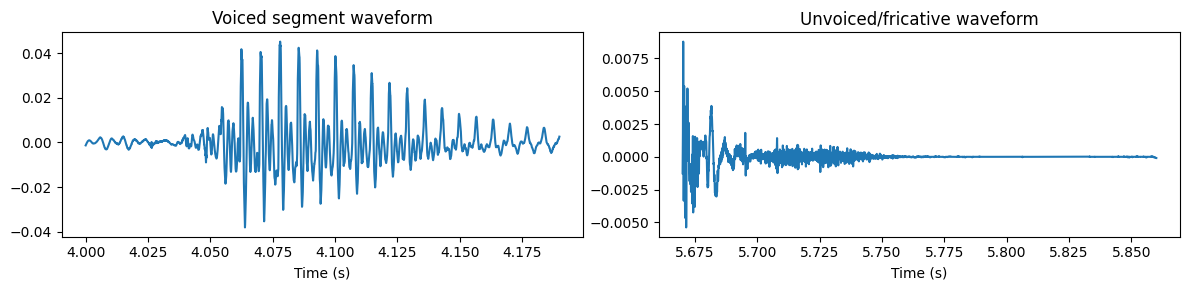

In [11]:
voiced_choice = max(voiced_info, key=lambda x: x['periodicity'])
unvoiced_choice = max(unvoiced_info, key=lambda x: x['zcr_mean'])

print("Voiced chosen:", voiced_choice['start_s'], voiced_choice['end_s'], voiced_choice['periodicity'])
print("Unvoiced chosen:", unvoiced_choice['start_s'], unvoiced_choice['end_s'], unvoiced_choice['zcr_mean'])

plt.figure(figsize=(12,3))
t1 = np.linspace(voiced_choice['start_s'], voiced_choice['end_s'], len(voiced_choice['samples']))
plt.subplot(1,2,1)
plt.plot(t1, voiced_choice['samples'])
plt.title('Voiced segment waveform')
plt.xlabel('Time (s)')

t2 = np.linspace(unvoiced_choice['start_s'], unvoiced_choice['end_s'], len(unvoiced_choice['samples']))
plt.subplot(1,2,2)
plt.plot(t2, unvoiced_choice['samples'])
plt.title('Unvoiced/fricative waveform')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()


CSV written to /content/phoneme_segments.csv
Saved voiced_choice.wav and unvoiced_choice.wav in /content/segments


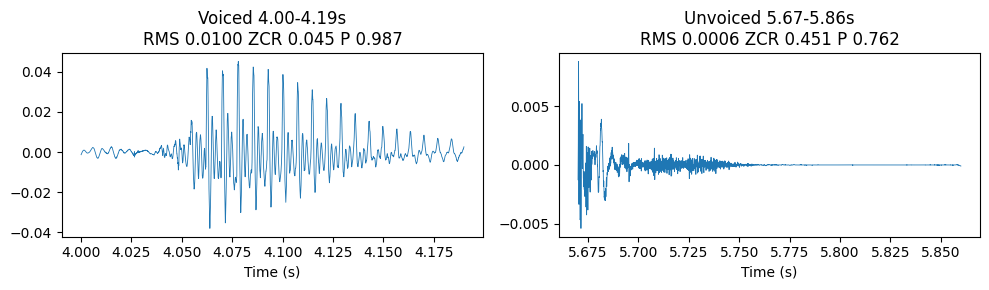

In [12]:
import csv, os
segments = []

def heuristic_category(info):
    z = info['zcr_mean']
    p = info['periodicity']
    dur = info['duration_s']
    rms = info['rms']
    if p > 0.85 and z < 0.12 and dur > 0.05:
        return 'vowel/sonorant'
    if z > 0.4 and p < 0.7:
        return 'fricative/unvoiced'
    if dur < 0.04 and rms > 0.02:
        return 'plosive/stop'
    if 0.7 <= p <= 0.85 and z < 0.2:
        return 'semivowel/diphthong'
    if p < 0.6 and rms < 0.02:
        return 'whisper/low-energy'
    return 'unknown'

for info in voiced_info:
    info['category'] = heuristic_category(info)
    info['type'] = 'voiced'
    segments.append(info)
for info in unvoiced_info:
    info['category'] = heuristic_category(info)
    info['type'] = 'unvoiced'
    segments.append(info)

segments = sorted(segments, key=lambda x: x['start_s'])
csv_path = '/content/phoneme_segments.csv'
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['start_s','end_s','duration_s','rms','zcr_mean','zcr_var','periodicity','type','category'])
    for s in segments:
        writer.writerow([f"{s['start_s']:.4f}", f"{s['end_s']:.4f}", f"{s['duration_s']:.4f}",
                         f"{s['rms']:.6f}", f"{s['zcr_mean']:.6f}", f"{s['zcr_var']:.6f}",
                         f"{s['periodicity']:.6f}", s['type'], s['category']])
print("CSV written to", csv_path)

import soundfile as sf
voiced_choice = max([s for s in segments if s['type']=='voiced'], key=lambda x: x['periodicity'])
unvoiced_choice = max([s for s in segments if s['type']=='unvoiced'], key=lambda x: x['zcr_mean'])

os.makedirs('/content/segments', exist_ok=True)
sf.write('/content/segments/voiced_choice.wav', voiced_choice['samples'], sr)
sf.write('/content/segments/unvoiced_choice.wav', unvoiced_choice['samples'], sr)
print("Saved voiced_choice.wav and unvoiced_choice.wav in /content/segments")

import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
t1 = np.linspace(voiced_choice['start_s'], voiced_choice['end_s'], len(voiced_choice['samples']))
plt.subplot(1,2,1)
plt.plot(t1, voiced_choice['samples'], linewidth=0.6)
plt.title(f"Voiced {voiced_choice['start_s']:.2f}-{voiced_choice['end_s']:.2f}s\nRMS {voiced_choice['rms']:.4f} ZCR {voiced_choice['zcr_mean']:.3f} P {voiced_choice['periodicity']:.3f}")
plt.xlabel('Time (s)')

t2 = np.linspace(unvoiced_choice['start_s'], unvoiced_choice['end_s'], len(unvoiced_choice['samples']))
plt.subplot(1,2,2)
plt.plot(t2, unvoiced_choice['samples'], linewidth=0.6)
plt.title(f"Unvoiced {unvoiced_choice['start_s']:.2f}-{unvoiced_choice['end_s']:.2f}s\nRMS {unvoiced_choice['rms']:.4f} ZCR {unvoiced_choice['zcr_mean']:.3f} P {unvoiced_choice['periodicity']:.3f}")
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()


“She sees you.”

Conversion successful: WAV file saved.
Signal Loaded. Sampling Rate: 16000 Hz, Duration: 3.65 s


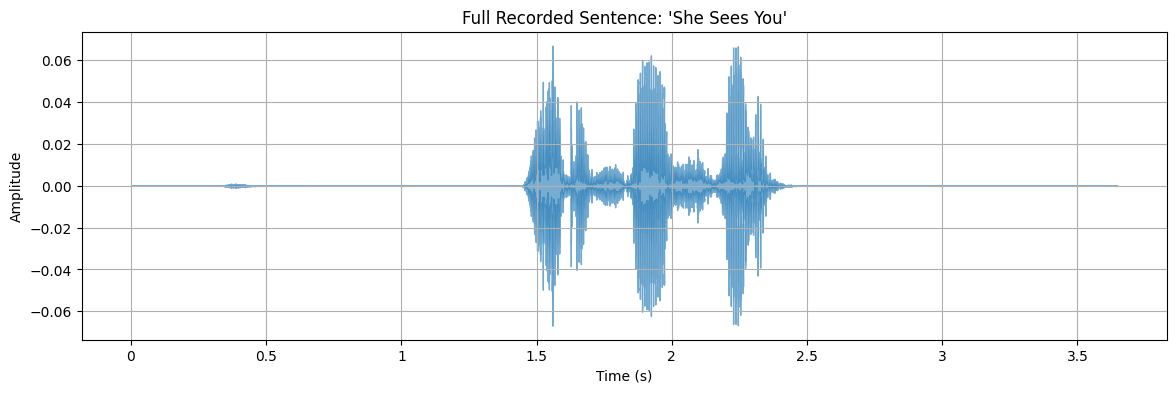

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from pydub import AudioSegment
import os

input_file = "/content/see_you_me.m4a"
output_wav = "/content/see_you_me_16k.wav"

if not os.path.exists(input_file):
    print(f"Error: File not found at {input_file}. Please check the path.")
else:
    audio = AudioSegment.from_file(input_file)
    audio = audio.set_frame_rate(16000).set_channels(1)
    audio.export(output_wav, format="wav")
    print("Conversion successful: WAV file saved.")

    y, sr = librosa.load(output_wav, sr=16000)
    print(f"Signal Loaded. Sampling Rate: {sr} Hz, Duration: {len(y)/sr:.2f} s")
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(y, sr=sr, alpha=0.6)
    plt.title("Full Recorded Sentence: 'She Sees You'")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

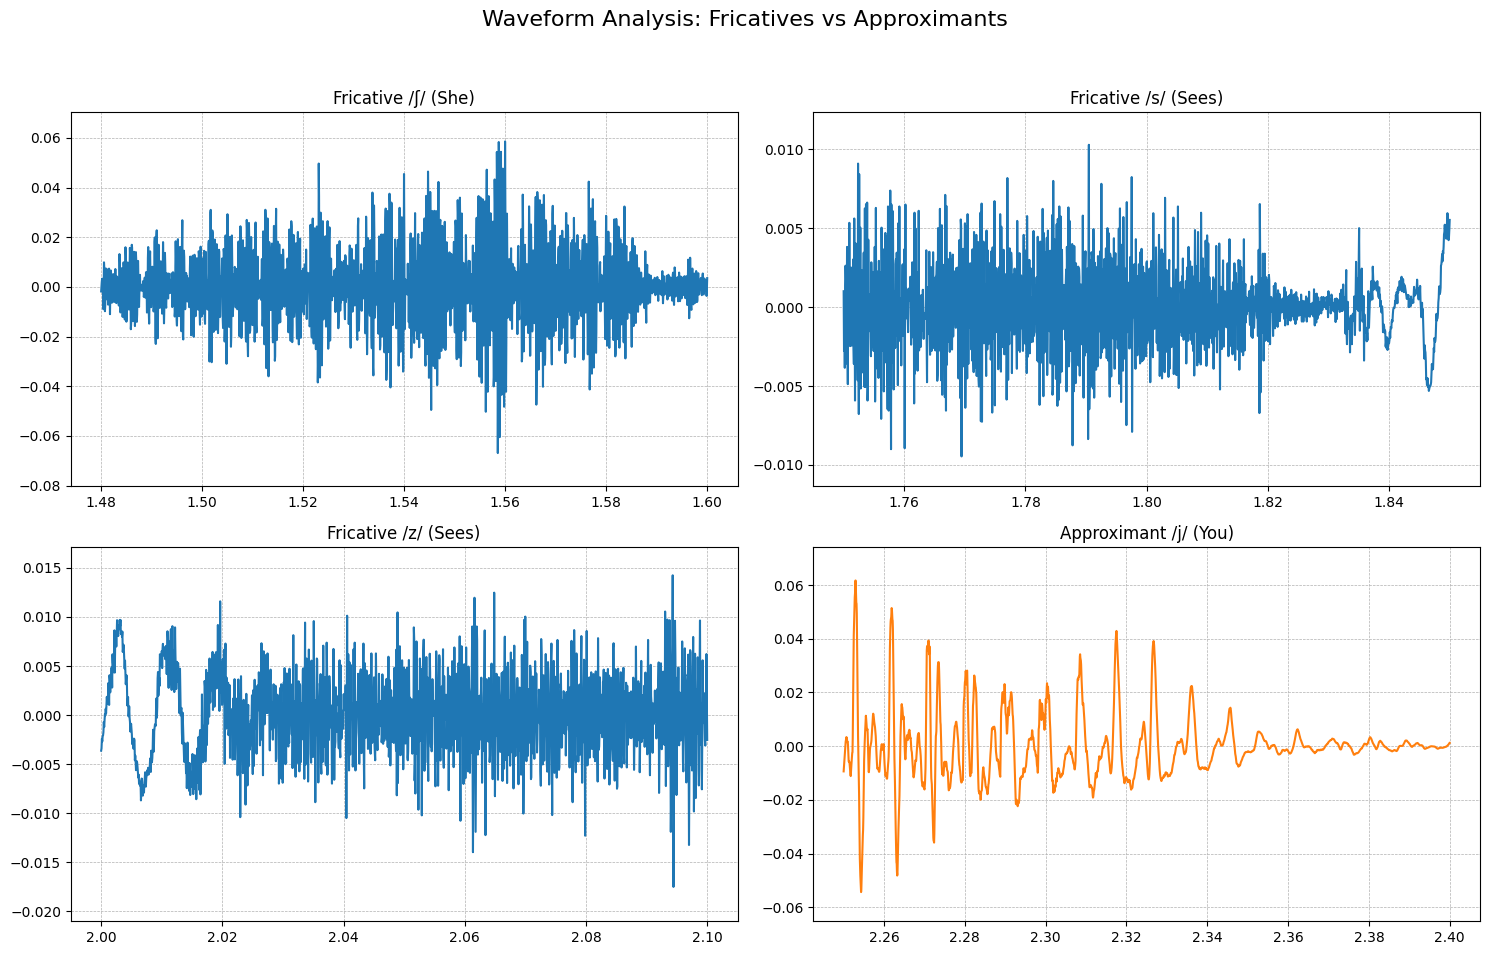


Phoneme                   | ZCR        | Inference
Fricative /ʃ/ (She)       | 0.2521     | Turbulent (High Re)
Fricative /s/ (Sees)      | 0.3179     | Turbulent (High Re)
Fricative /z/ (Sees)      | 0.2440     | Turbulent (High Re)
Approximant /j/ (You)     | 0.0229     | Laminar (Low Re)


In [20]:

def calculate_energy_zcr(y, frame_length=512, hop_length=256):
    energy = np.array([
        np.sum(np.abs(y[i:i+frame_length]**2))
        for i in range(0, len(y), hop_length)
    ])
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=frame_length, hop_length=hop_length)[0]
    return energy, zcr

frame_len = 512
hop_len = 256
energy, zcr = calculate_energy_zcr(y, frame_len, hop_len)

frames = range(len(energy))
t_features = librosa.frames_to_time(frames, sr=sr, hop_length=hop_len)


def get_slice(start_s, end_s):
    start_sample = int(start_s * sr)
    end_sample = int(end_s * sr)
    return y[start_sample:end_sample], np.linspace(start_s, end_s, end_sample-start_sample)


segments = {
    "Fricative /ʃ/ (She)":  (1.48, 1.60),
    "Fricative /s/ (Sees)": (1.75, 1.85),
    "Fricative /z/ (Sees)": (2.00, 2.10),
    "Approximant /j/ (You)": (2.25, 2.40)
}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Waveform Analysis: Fricatives vs Approximants", fontsize=16)
axes = axes.flatten()

analysis_results = []

for i, (name, (start, end)) in enumerate(segments.items()):
    start_sample = int(start * sr)
    end_sample = int(end * sr)
    segment_y = y[start_sample:end_sample]
    segment_t = np.linspace(start, end, len(segment_y))

    ax = axes[i]
    ax.plot(segment_t, segment_y, color='tab:blue' if 'Fricative' in name else 'tab:orange')
    ax.set_title(f"{name}")
    ax.set_ylim(np.min(segment_y)*1.2, np.max(segment_y)*1.2)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    seg_zcr = np.mean(librosa.feature.zero_crossing_rate(segment_y))
    inference = "Turbulent (High Re)" if seg_zcr > 0.05 else "Laminar (Low Re)"

    analysis_results.append({
        "Phoneme": name,
        "ZCR": seg_zcr,
        "Inference": inference
    })

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n" + "="*70)
print(f"{'Phoneme':<25} | {'ZCR':<10} | {'Inference'}")
print("="*70)
for res in analysis_results:
    print(f"{res['Phoneme']:<25} | {res['ZCR']:.4f}     | {res['Inference']}")
print("="*70)